In [1]:
import numpy as np
from skimage import filters, io
import cv2 as cv
from matplotlib import pyplot as plt
from scipy.ndimage import maximum_filter
from skimage.feature import corner_harris, corner_peaks

from myfunc.mysubplot import subplots

### Step1: Image gradients

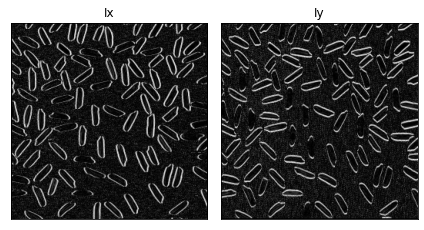

In [3]:
image = io.imread(fname="../../data/ass3/rice.png")
h,w = image.shape
# keep the output datatype to some higher forms
Ix = cv.Sobel(image,cv.CV_64F,1,0,ksize=1)
abs_Ix = np.absolute(Ix)
Ix_8u = np.uint8(abs_Ix)
Iy = cv.Sobel(image,cv.CV_64F,0,1,ksize=1)
abs_Iy = np.absolute(Iy)
Iy_8u = np.uint8(abs_Iy)

subplots([Ix_8u, Iy_8u], ['Ix', 'Iy'], 1,2)

### Step2: Second movement matrix M 

In [4]:
# Gaussian truncate window
kernel_size = 3
sigma = 0.5
Ixx = cv.GaussianBlur(Ix**2,(kernel_size,kernel_size), sigma)
Ixy = cv.GaussianBlur(Ix*Iy,(kernel_size,kernel_size), sigma)
Iyy = cv.GaussianBlur(Iy**2,(kernel_size,kernel_size), sigma)

offset = np.int8(kernel_size/2)
height, width = image.shape
corner_response = np.zeros((height, width))

# construct matrix elements
k = 0.02
for y in range(offset, height-offset):
    for x in range(offset, width-offset):
        A = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
        C = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
        B = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])
        det = (A * C) - (B**2)
        trace = A + C
        r = det - k*(trace**2)
        corner_response[y][x] = r

### Step3: Corner response calculation and Non-maximum suppression

In [7]:
# Response threshold 0.2*r_max 
r_max = np.max(corner_response)
r_threshold = corner_response > 0.2*r_max
# Non max suppression mask
NMS = (corner_response == maximum_filter(corner_response, 5))
mask = r_threshold & NMS
keypoints = np.argwhere(mask==True)

# compare with open source library
# keypoints = corner_peaks(corner_harris(image), min_distance=5, threshold_rel=0.02)